In [1]:
'''
SCC5830 - Image Processing
Final Project
2019 - 1st semester

Image restoration: Sinusoidal noise removal
 
'''


'\nSCC5830 - Image Processing\nFinal Project\n2019 - 1st semester\n\nImage restoration: Sinusoidal noise removal\n \n'

In [3]:
import numpy as np
from scipy.fftpack import fftn, ifftn, fftshift
import matplotlib.pyplot as plt
import imageio
from PIL import Image

In [21]:
def get_img():
    filename = str(input()).rstrip()
    img = imageio.imread(filename)
    return img

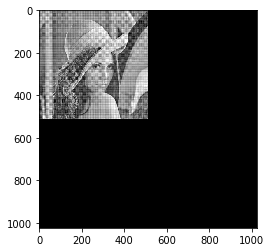

In [17]:
#m, n = img.shape
#nimg = np.zeros((m*2,n*2))
#nimg[:m,:n] = img
#plt.figure()
#plt.imshow(nimg, cmap = "gray")

In [22]:
def spatialtofreq(img):
    m, n = img.shape
    nimg = np.zeros((m*2,n*2))
    nimg[:m,:n] = img
    ftimg = fftn(nimg) 
    ftimg = fftshift(ftimg)
    return ftimg

In [42]:
def freqtospatial(fimg, img):
    m, n = img.shape
    image = np.abs(fftn(fimg))
    image = image.astype(np.uint8)
    crop_img = image.crop((0, 0, m, n))
    return(crop_img)

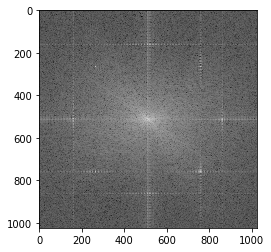

In [8]:
#ftimg = fftn(nimg)
#m, n = ftimg.shape
#ftimg = (np.log(1+np.abs(fftshift(ftimg))))
#plt.imshow(np.real(ftimg), cmap = "gray")


In [24]:
def butterWorthFilter(euclideand, cutofffrequency, bandwidth, order):
            result = 1/(1+((euclideand*bandwidth)/((euclideand**2)-(cutofffrequency**2)))**(2.*order))
            return result

In [25]:
def gaussianFilter(euclideand, cutofffrequency, bandwidth):
            result = 1-exp(-((euclideand**2-cutofffrequency**2)/(euclideand*bandwidth))**2)
            return result

In [26]:
def createBandFilter(m, n, type, cutofffrequency, bandwidth, order):
    img = np.zeros((m,n))
    cx = np.floor(m/2)+1
    cy = np.floor(n/2)+1
    for x in range(m):
        for y in range(n):
            euclideand = np.sqrt((x-cx)**2+(y-cy)**2)
            if(type == "ideal"):
                img[x,y] = idealFilter(euclideand, cutofffrequency, bandwidth)
                return img
            elif(type == "butterworth"):
                img[x,y] = butterWorthFilter(euclideand, cutofffrequency, bandwidth, order)
                return img
            elif(type == "gaussian"):
                img[x,y] = gaussianFilter(euclideand, cutofffrequency, bandwidth, domain)
                return img

lena_corrupted.png


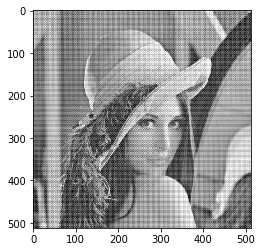

In [28]:
img = get_img()
plt.imshow(img, cmap = "gray")

In [ ]:
#fimg = fftn(img)
#fimg = (np.log(1+np.abs(fftshift(fimg))))
#plt.figure()
#plt.imshow(fimg, cmap = "gray")

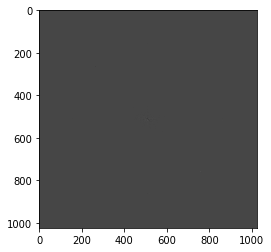

In [30]:
fimg = spatialtofreq(img)
plt.imshow(np.real(fimg), cmap = "gray")

In [31]:
m,n = fimg.shape
bandwidth = 40
cutofffrequency = 120

In [32]:
rejectBandFilter = createBandFilter(m, n, "butterworth", cutofffrequency, bandwidth, 2)

In [43]:
filteredImageRejectBandIdeal =freqtospatial(np.multiply(ftimg,rejectBandFilter),img)

AttributeError: 'numpy.ndarray' object has no attribute 'crop'